# ***1.  Define the Problem Statement***

1.   Assess the projected rate of EV adoption in California.
    <br><i><u>
    Predict the number of electric vehicles sales in the next 5 years.
    </u></i></br>
2.   Assess the impact on electricity demand as a result of EV adoption
    <br><i><u>
    Compare the electricity consumption vs demand and forecast it for the next 5 years.
    </u></i></br>
3.   Assess if the rate of deployment of EV charging stations meets the projected needs.
    <br><i><u>
    Predict the number of charging stations over the next 5 years and validate if that meets the needs.
    </u></i></br>

<br></br>

# ***2.  Model Outcomes or Predictions:***
Regression model will be used here as the primary idea behind this exercise is to determine:
*   the number of electric vehicles sold in the future
*   the increase in demand for electricity consumption
*   the number of charging stations installed in the future

<br></br>

# ***3.  Data Acquisition:***
The data necessary for this analysis is gathered from [State of California Data Catalog site](https://catalog.data.gov/dataset)
<br></br>
The data includes:
*   Light-duty vehicle sales data
*   Zero emission vehicle sales data
*   Electric charging stations data
*   Hydrogen refueling stations data
<br></br>
Light-duty vehicle sales data has the following fields:
*   Data Year, Quarter, COUNTY
*   Zero Emission Vehicle Sales,	Total Light-Duty Vehicle Sales
*   Zero Emission Vehicle Sales Share

<br></br>
Zero emission vehicle sales data has the following fields:
*   Data Year,	Quarter,	COUNTY
*   FUEL_TYPE,	MAKE,	MODEL
*   Number of Vehicles sold

<br></br>
Electric charging stations data has the following fields:
*   County
*   Public Level 1,	Public Level 2,	Public DC Fast
*   Shared Private Level 1,	Shared Private Level 2, Shared Private DC Fast
*   Total,	Date

<br></br>
Hydrogen refueling stations data has the following fields:
*   Station Number,	Station Name,	Open Retail Status
*   Address	City,	State,	Zip Code,	County
*   Number of Stations,	Fueling Positions

In [2]:
# Import all necessary libraries necessary for the project

import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.dummy import DummyClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso

# ***4.  Data Preprocessing/Preparation:***
# ** Techniques used for analysis and encoding:**
For the most part the data provided was pretty clean to begin with, very minimal effort was needed.  [As the data was acquired from CA government website, the data was ready to be consumed].
*   Rows with no sales data was dropped from the analysis
*   Date fields were formatted into consistent YYYYQQ format
*   Numeric and % were also formatted to appropriate values
*   Data was split into 80 / 20 groups for training and test data set

In [3]:
# Load the source data gathered from https://www.energy.ca.gov/files/zev-and-infrastructure-stats-data
# Perform basic data cleanup

#Load Light-Duty Vehicle sales data
ldv_sales_df = pd.read_csv('/bin/data/LDV_Sales.csv')
ldv_sales_df.dropna(inplace=True)
print("Light-Duty Vehicle sales data")
#display(ldv_sales_df.info())
display(ldv_sales_df.head())
print("=========================================================================")

#Load Zero Emission Vehicle sales data
zev_sales_df = pd.read_csv('/bin/data/ZEV_Sales.csv')
zev_sales_df.dropna(inplace=True)
print("Zero Emission Vehicle sales data")
#display(zev_sales_df.info())
display(zev_sales_df.head())
print("=========================================================================")

#Load Electric Charging stations data
ev_chargers_df = pd.read_csv('/bin/data/EV_Chargers.csv')
ev_chargers_df.dropna(inplace=True)
ev_chargers_df = ev_chargers_df[ev_chargers_df['County'] != 'Total']
ev_chargers_df['Date'] = ev_chargers_df['Date'].astype(str).str.replace(r'(Q\d)\s*(\d{4})', r'\2\1', regex=True)
print("Electric Charging stations data")
#display(ev_chargers_df.info())
display(ev_chargers_df.head())
print("=========================================================================")

#Load Hydrogen Refueling stations data
hrs_df = pd.read_csv('/bin/data/Hydrogen_Refueling_Stations.csv')
hrs_df.dropna(inplace=True)
hrs_df = hrs_df.drop(['Latitude', 'Longitude'], axis=1)
print("Hydrogen Refueling stations data")
#display(hrs_df.info())
display(hrs_df.head())
print("=========================================================================")

Light-Duty Vehicle sales data


,Data Year,Quarter,COUNTY,ZEV Sales,Total LDV Sales,ZEV Sales Share
0,2025,1,Alameda,5525,14812,37%
1,2025,1,Alpine,0,3,0%
2,2025,1,Amador,31,234,13%
3,2025,1,Butte,118,1109,11%
4,2025,1,Calaveras,38,311,12%


Zero Emission Vehicle sales data


,Data Year,Quarter,COUNTY,FUEL_TYPE,MAKE,MODEL,Number of Vehicles
0,2008,3,Alameda,Electric,Tesla,Roadster,1
1,2008,3,San Francisco,Electric,Tesla,Roadster,1
2,2008,3,San Mateo,Electric,Tesla,Roadster,3
3,2008,3,Santa Clara,Electric,Tesla,Roadster,4
4,2008,3,Sonoma,Electric,Tesla,Roadster,1


Electric Charging stations data


,County,Public Level 1,Shared Private Level 1,Public Level 2,Shared Private Level 2,Public DC Fast,Shared Private DC Fast,Total,Date
0,Alameda,4.0,72.0,2622.0,4040.0,898.0,102.0,7738.0,2025Q1
1,Alpine,0.0,0.0,20.0,2.0,0.0,0.0,22.0,2025Q1
2,Amador,0.0,0.0,55.0,4.0,8.0,0.0,67.0,2025Q1
3,Butte,0.0,0.0,175.0,99.0,41.0,0.0,315.0,2025Q1
4,Calaveras,0.0,2.0,19.0,6.0,21.0,0.0,48.0,2025Q1


Hydrogen Refueling stations data


,Station Number,Station Name,Open Retail Status,Address,City,State,Zip Code,County,Number of Stations,Fueling Positions
0,1,Diamond Bar,Light-Duty Open Retail,21865 E. Copley Drive,Diamond Bar,CA,91765,Los Angeles,1,1
1,2,West Sacramento,Light-Duty Open Retail,1515 S. River Road,West Sacramento,CA,95691,Yolo,1,2
2,3,San Juan Capistrano,Light-Duty Open Retail,26572 Junipero Serra Rd.,San Juan Capistrano,CA,92675,Orange,1,2
3,4,Fairfax,Light-Duty Open Retail,7751 Beverly Blvd.,Los Angeles,CA,90036,Los Angeles,1,1
4,5,Lawndale,Light-Duty Open Retail,15606 Inglewood Ave.,Lawndale,CA,90260,Los Angeles,1,1


# **Observation**

Based on the initial analysis, the data seems be to pretty clean and good to proceed for initial analysis.  If necessary we will come back to clean-up or create any necessary feields as necessary.

,Data Year,Quarter,Total LDV Sales,ZEV Sales,YearQuarter
YearQuarter,,,,,
2008Q1,2008,1,191811,0,2008Q1
2008Q2,2008,2,217078,0,2008Q2
2008Q3,2008,3,204652,10,2008Q3
2008Q4,2008,4,155737,65,2008Q4
2009Q1,2009,1,139711,51,2009Q1


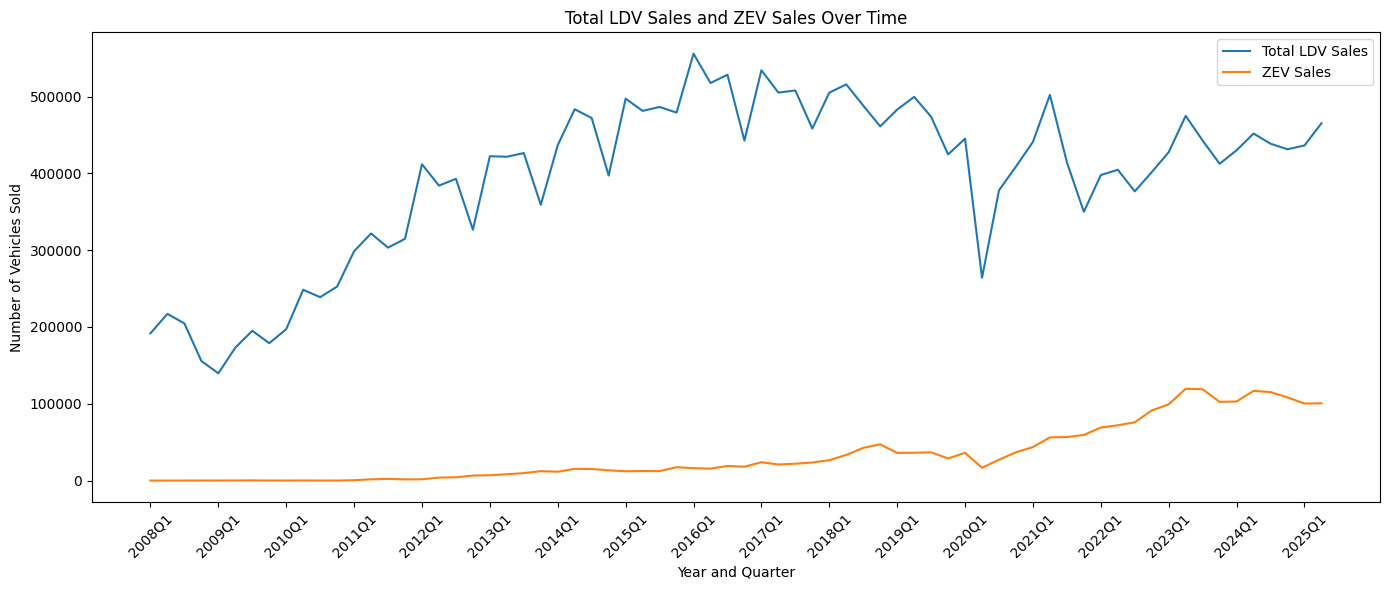

In [4]:
# Prepare and plot the Total car sales vs Zero-emission car sales -- Start

sales_by_quarter = ldv_sales_df.groupby(['Data Year', 'Quarter'])[['Total LDV Sales', 'ZEV Sales']].sum().reset_index()
#display(sales_by_quarter.head())

#Use the YearQuarter as the new index, beneficial for plotting
sales_by_quarter['YearQuarter'] = sales_by_quarter['Data Year'].astype(str) + 'Q' + sales_by_quarter['Quarter'].astype(str)
sales_by_quarter.index = pd.PeriodIndex(sales_by_quarter['YearQuarter'], freq='Q')
display(sales_by_quarter.head())

# Set appropriate charting labels
plt.figure(figsize=(14, 6))
plt.plot(sales_by_quarter.index.astype(str), sales_by_quarter['Total LDV Sales'], label='Total LDV Sales')
plt.plot(sales_by_quarter.index.astype(str), sales_by_quarter['ZEV Sales'], label='ZEV Sales')
plt.xlabel('Year and Quarter')
plt.ylabel('Number of Vehicles Sold')
plt.title('Total LDV Sales and ZEV Sales Over Time')
plt.legend()
plt.xticks(sales_by_quarter.index.astype(str)[::4], rotation=45) # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()
# Prepare and plot the Total car sales vs Zero-emission car sales -- End

# **Observation**

Based on the simple plot of vehicle sales of ICE (Internal combustion Engine) vs. ZEV (Zero Emission Vehicles), seems like ZEV have a long way to go.  We need approximately 3x - 4x the sales of current ZEV sold to just to catchup and meet the current demands.

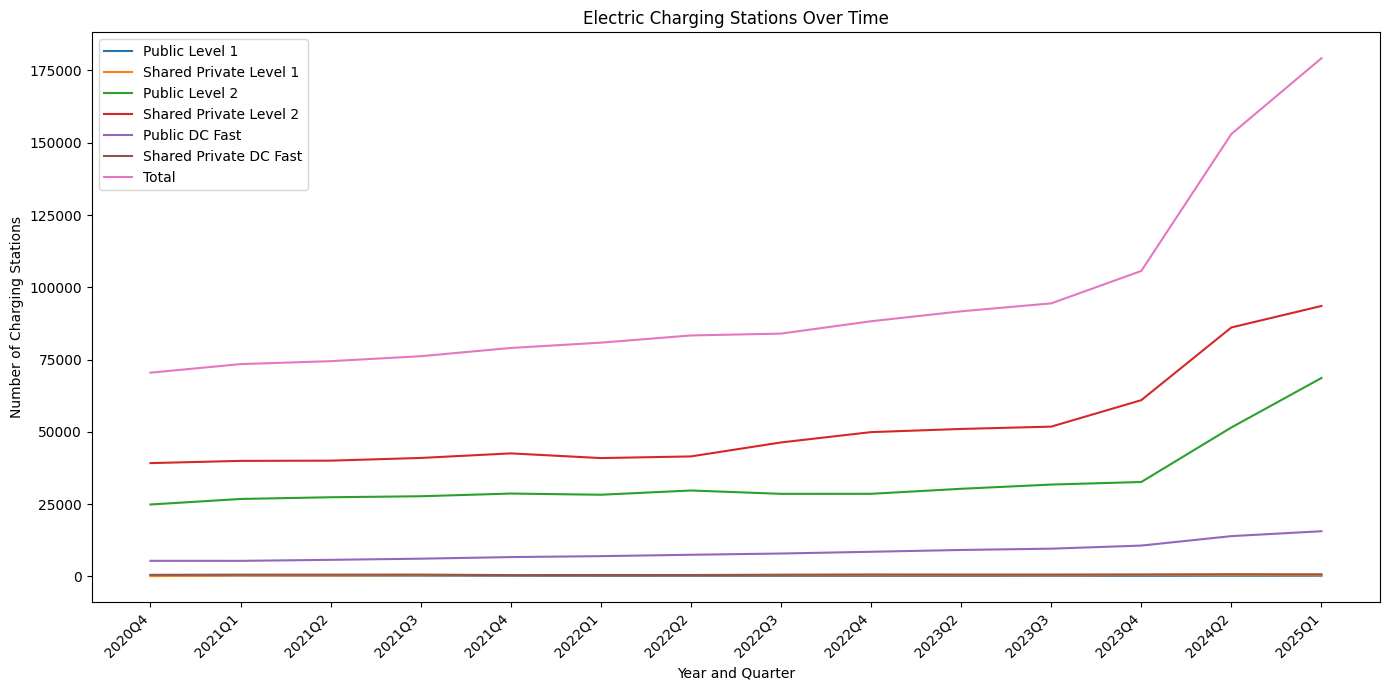

In [5]:
# Convert the 'Date' column to a proper time series format (e.g., Period) for plotting
ev_chargers_df['Date_Period'] = pd.PeriodIndex(ev_chargers_df['Date'], freq='Q')

# Group by Date and sum the charging station types and total
charging_over_time = ev_chargers_df.groupby('Date_Period')[['Public Level 1', 'Shared Private Level 1', 'Public Level 2', 'Shared Private Level 2', 'Public DC Fast', 'Shared Private DC Fast', 'Total']].sum().reset_index()

# Plot the data
plt.figure(figsize=(14, 7))

for column in ['Public Level 1', 'Shared Private Level 1', 'Public Level 2', 'Shared Private Level 2', 'Public DC Fast', 'Shared Private DC Fast', 'Total']:
    plt.plot(charging_over_time['Date_Period'].astype(str), charging_over_time[column], label=column)

plt.xlabel('Year and Quarter')
plt.ylabel('Number of Charging Stations')
plt.title('Electric Charging Stations Over Time')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# **Observation**

Based on the above chat, looks like the deployment of number of electric charging stations have picked up in the past couple of years and this will need to continue if the expected sales of ZEV is grow at 3x - 4x pace.

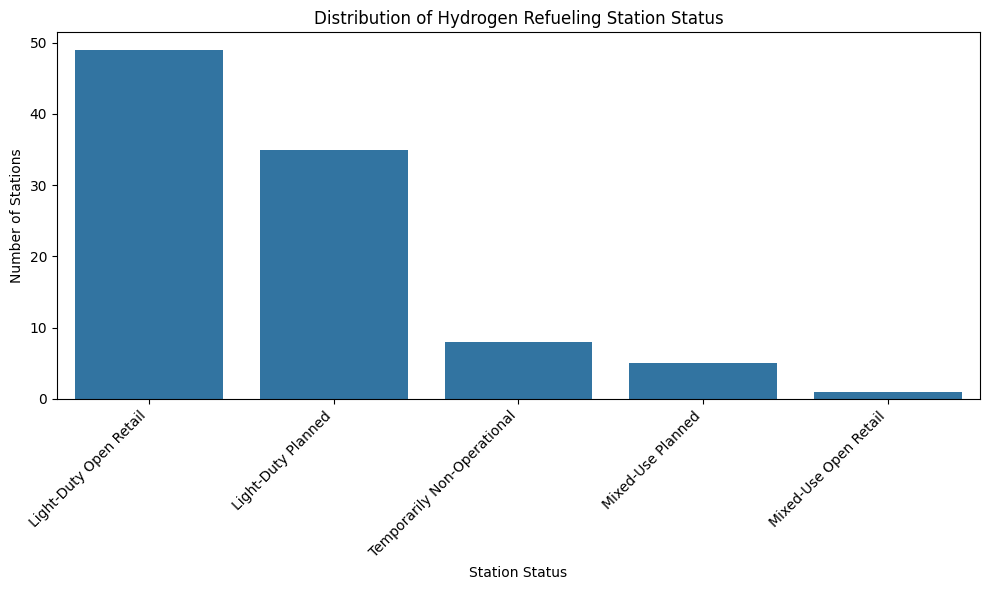

In [6]:
# Plot hydrogen fueling stations data

status_counts = hrs_df['Open Retail Status'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=status_counts.index, y=status_counts.values)
plt.xlabel('Station Status')
plt.ylabel('Number of Stations')
plt.title('Distribution of Hydrogen Refueling Station Status')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

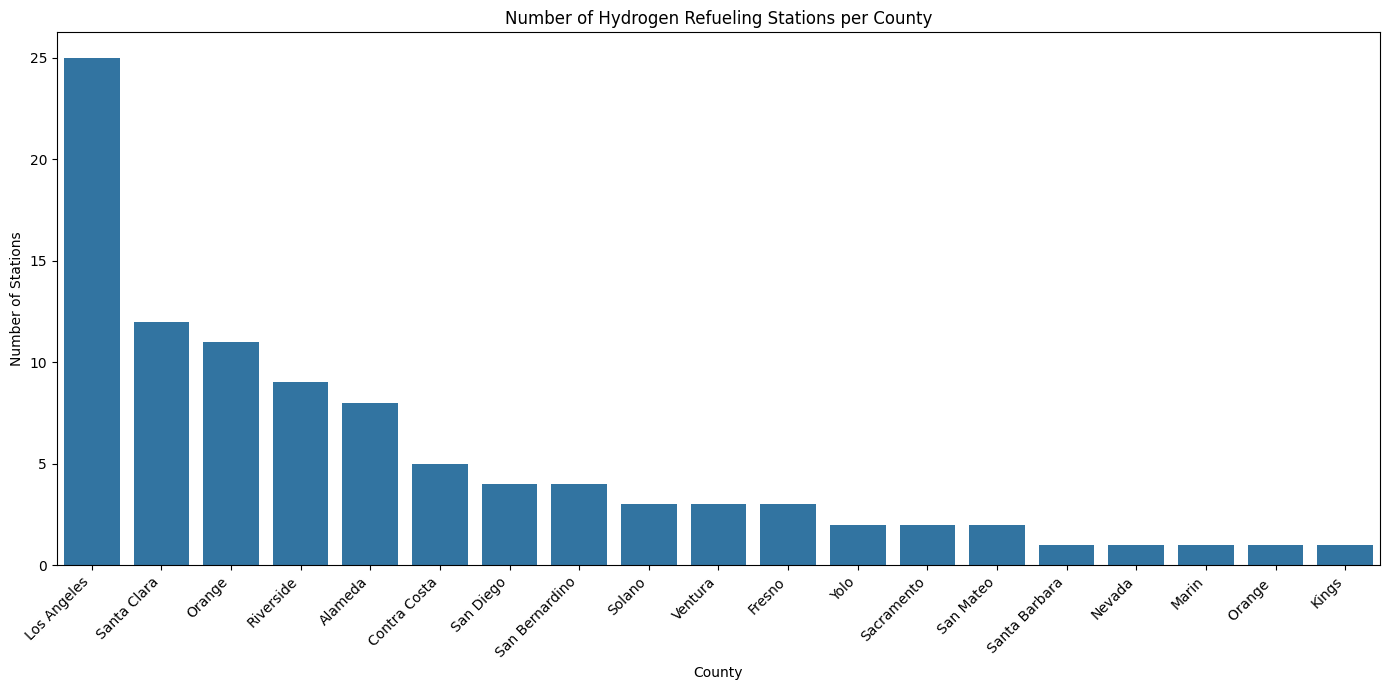

In [7]:
#Plot to visualize hydrogen refueling stations in each county

county_counts = hrs_df['County'].value_counts()
plt.figure(figsize=(14, 7))
sns.barplot(x=county_counts.index, y=county_counts.values)
plt.xlabel('County')
plt.ylabel('Number of Stations')
plt.title('Number of Hydrogen Refueling Stations per County')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# **Observation**

Based on the hydrogen station deployment, it looks like this will need significant increase in deployment

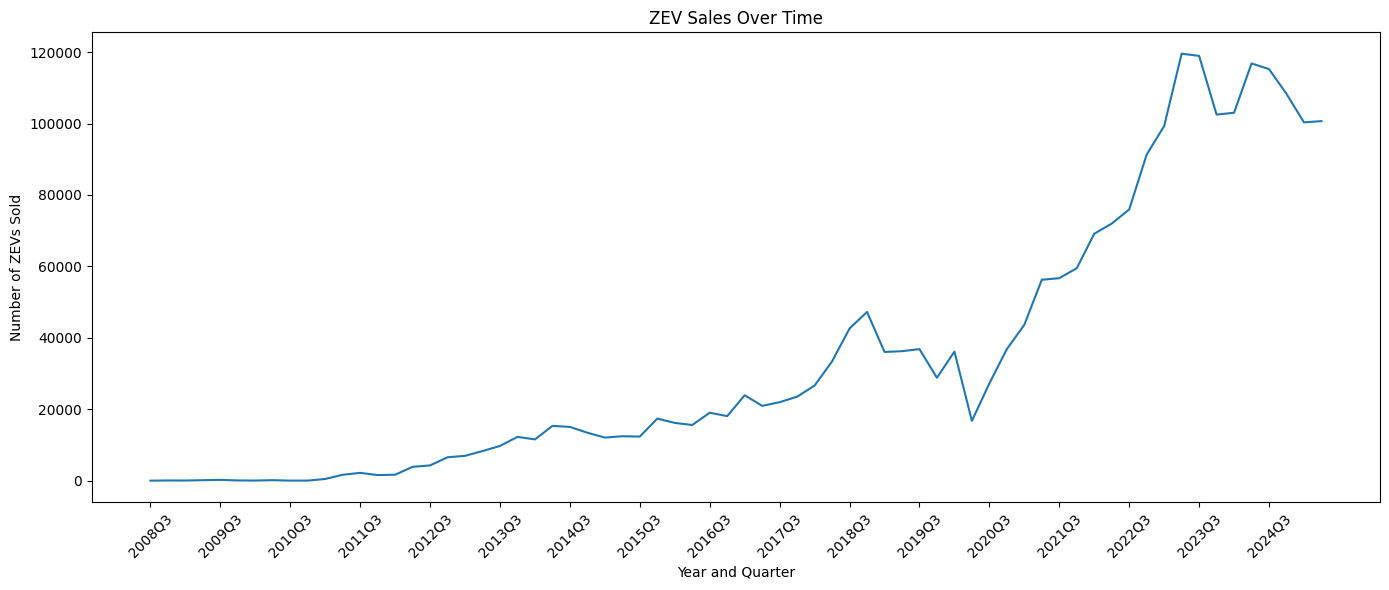

In [8]:
#Plot to visualize Zero-Emission Vehicle sales over time

zev_sales_by_quarter = zev_sales_df.groupby(['Data Year', 'Quarter'])['Number of Vehicles'].sum().reset_index()

zev_sales_by_quarter['YearQuarter'] = zev_sales_by_quarter['Data Year'].astype(str) + 'Q' + zev_sales_by_quarter['Quarter'].astype(str)
zev_sales_by_quarter.index = pd.PeriodIndex(zev_sales_by_quarter['YearQuarter'], freq='Q')

plt.figure(figsize=(14, 6))
plt.plot(zev_sales_by_quarter.index.astype(str), zev_sales_by_quarter['Number of Vehicles'])
plt.xlabel('Year and Quarter')
plt.ylabel('Number of ZEVs Sold')
plt.title('ZEV Sales Over Time')
plt.xticks(zev_sales_by_quarter.index.astype(str)[::4], rotation=45)
plt.tight_layout()
plt.show()

# **Observation**

Based on the ZEV historic vehicles sales data, seems like the sales have stalled over the past few years.  A little more analysis is necessary to identify is this is just a problem with the data or is it a result of some of the current policies.

As mentioned earlier if the ZEV is to replace ICE vehicles sales, then this is certainly a concern.

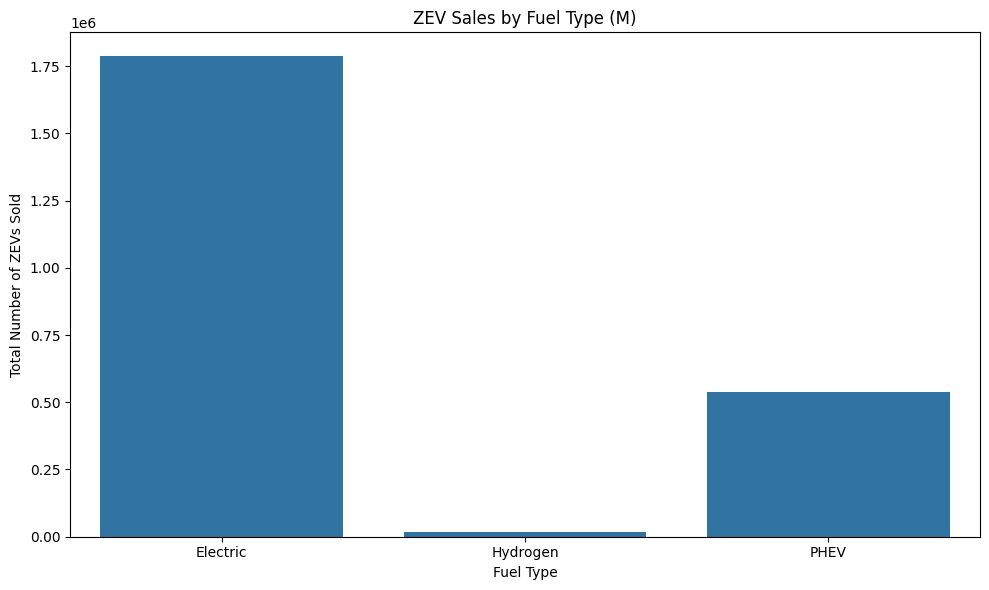

In [9]:
#Visualize the distribution of ZEV sales across different fuel types (Electric, PHEV, etc.).

fuel_type_counts = zev_sales_df.groupby('FUEL_TYPE')['Number of Vehicles'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='FUEL_TYPE', y='Number of Vehicles', data=fuel_type_counts)
plt.xlabel('Fuel Type')
plt.ylabel('Total Number of ZEVs Sold')
plt.title('ZEV Sales by Fuel Type (M)')
plt.tight_layout()
plt.show()

# **Observation**

As expected, this clearly indicates the most popular vehicle type in the ZEV category is Fully Electric vehicles.  The second best

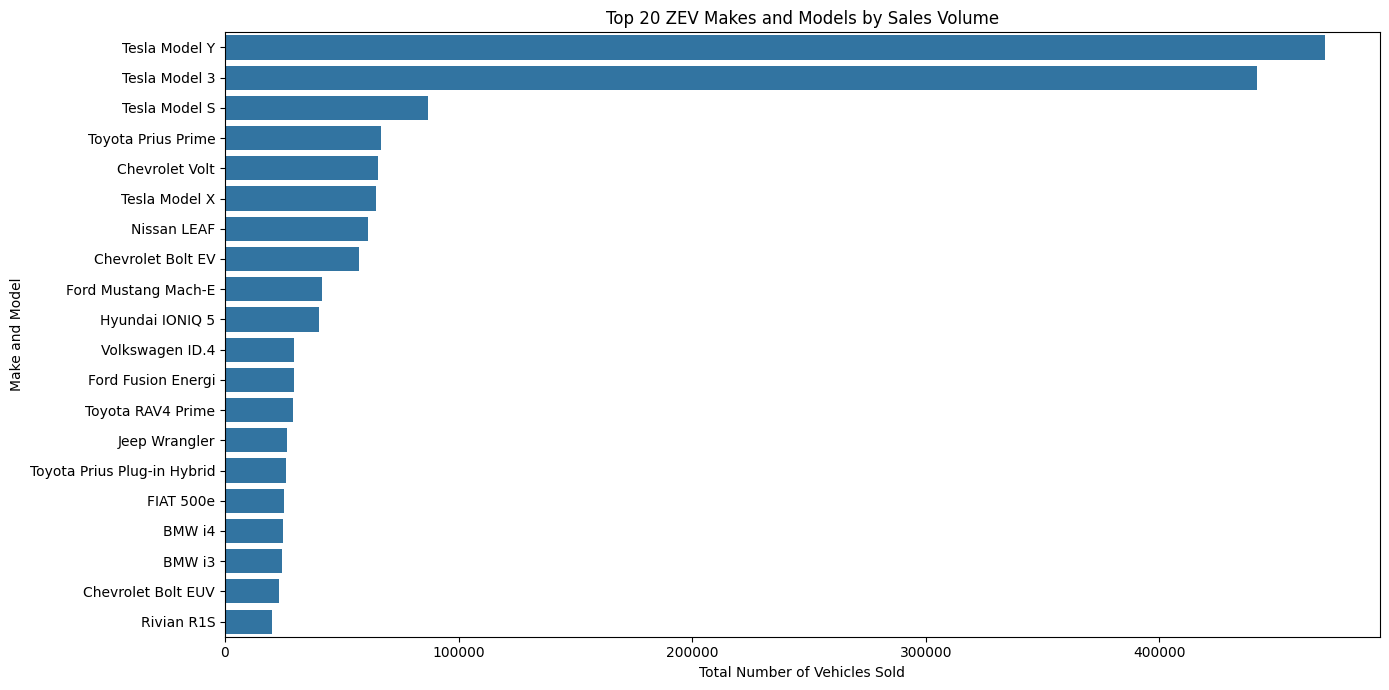

In [10]:
# Explore the top ZEV makes and models by sales volume.
# Group the zev_sales_df DataFrame by 'MAKE' and 'MODEL

make_model_sales = zev_sales_df.groupby(['MAKE', 'MODEL'])['Number of Vehicles'].sum().reset_index()
top_make_models = make_model_sales.sort_values(by='Number of Vehicles', ascending=False).head(20)

plt.figure(figsize=(14, 7))
sns.barplot(x='Number of Vehicles', y=top_make_models['MAKE'] + ' ' + top_make_models['MODEL'], data=top_make_models)
plt.xlabel('Total Number of Vehicles Sold')
plt.ylabel('Make and Model')
plt.title('Top 20 ZEV Makes and Models by Sales Volume')
plt.tight_layout()
plt.show()

# **Observation**

Again, clearly not a surprse the most popular vehicle sold (in-fact the top 3) are Tesla.  Infact the top 2 are close to 5 times the sales of any other vehicle type sold.

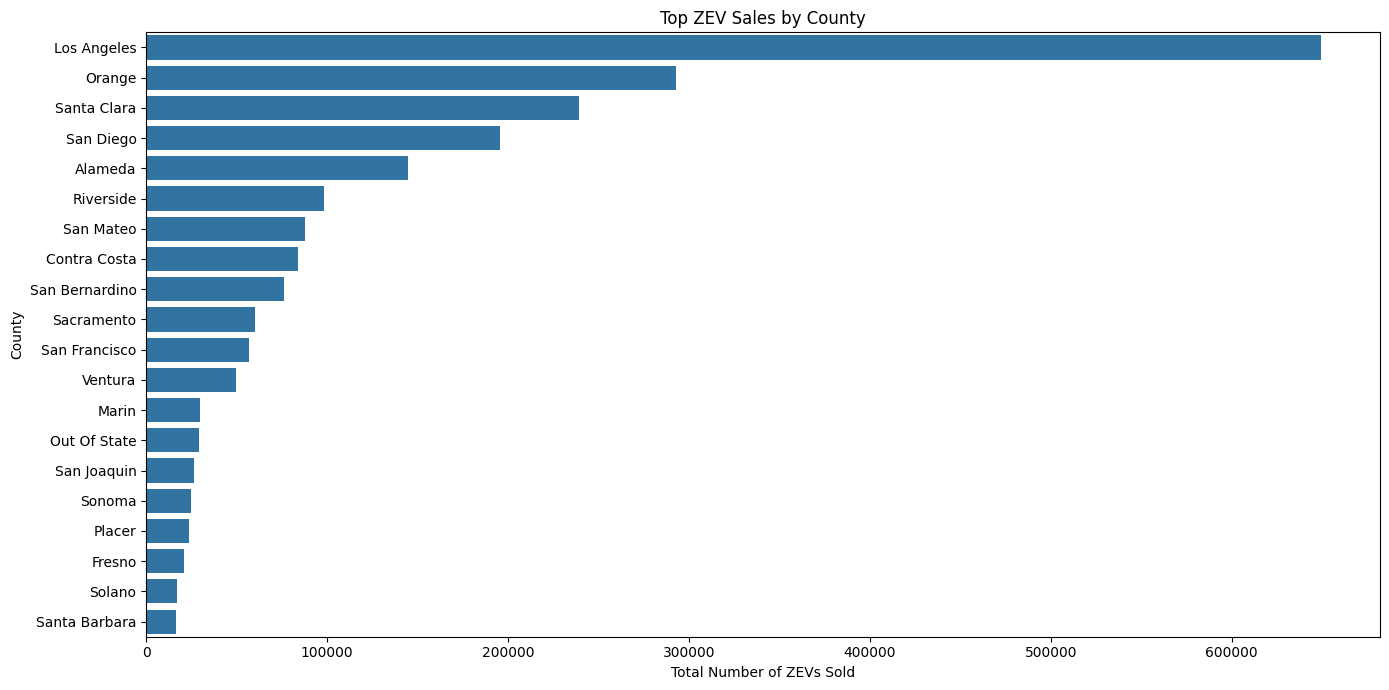

In [11]:
#Visualize the geographical distribution of ZEV sales across different counties.

county_zev_sales = zev_sales_df.groupby('COUNTY')['Number of Vehicles'].sum().reset_index()
county_zev_sales_sorted = county_zev_sales.sort_values(by='Number of Vehicles', ascending=False)
top_20_counties = county_zev_sales_sorted.head(20)

plt.figure(figsize=(14, 7))
sns.barplot(x='Number of Vehicles', y='COUNTY', data=top_20_counties)
plt.xlabel('Total Number of ZEVs Sold')
plt.ylabel('County')
plt.title('Top ZEV Sales by County')
plt.tight_layout()
plt.show()

# **Observation**

This just shows the distribution of vechiles sold and the top few cities in california.

# ***5.  Modeling - Baseline modeling:***

Since the task is to predict sales volume, a simple Linear Regression model should serve as a baseline.

In [12]:

# For demonstration, let's use 'Data Year' to predict 'Number of Vehicles'
X = zev_sales_df[['Data Year']]
y = zev_sales_df['Number of Vehicles']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Linear Regression model
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

# Evaluate the model (using R-squared as a simple metric)
r_squared = baseline_model.score(X_test, y_test)
print(f"Baseline Linear Regression Model R-squared: {r_squared}")

# Make predictions on the test set
y_pred = baseline_model.predict(X_test)

# Calculate regression metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r2}")

# This can now serve as the 'baseline_model' for comparison with other more complex models for analysis.

Baseline Linear Regression Model R-squared: 0.0004936251325029506
Mean Absolute Error (MAE): 49.04106058835914
Mean Squared Error (MSE): 35749.20883963423
Root Mean Squared Error (RMSE): 189.07461183256262
R-squared: 0.0004936251325029506


# **Interpretation of evaluation metrics**

***R-squared***: Represents the variance in the dependent variable (ZEV Sales) that is predictable from the independent variable (Data Year).  The low value in this case indicates that 'Year' alone is not a good fit and is a poor predictor of ZEV sales.

***Mean Absolute Error***: The average of the absolute differences between the actual and predicted values.  This simple metric indicates the average model's predictions for ZEV sales are off by approximately 49 vehicles.

***Mean Squared Error***: The average of the squared differences between the actual and predicted values.  The high values indicates larger prediction errors, as this model penalizes larger more heavely as the errors are squared.

***Root Mean Squared Error***: The square root of the Mean Squared Error.  This metric indicates the average model's predictions for ZEV sales are off by approximately 189 vehicles.  This is much higher than MAE, further indicating larger errors in the model prediction.

# ***5.  Modeling - Targetted modeling:***
As a next step a couple of regression models are used to further improve on the baseline model:
*   Random Forest
*   Gradient Boost


In [13]:
# Use the same data split as the baseline model; X_train, X_test, y_train, y_test

# Initialize and train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate Random Forest model
y_pred_rf = rf_model.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("RandomForest Metrics:")
print(f"Mean Absolute Error (MAE): {mae_rf}")
print(f"Mean Squared Error (MSE): {mse_rf}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf}")
print(f"R-squared: {r2_rf}")
print("=========================================================================")

# Initialize and train Gradient Boost model
gbr_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gbr_model.fit(X_train, y_train)

# Evaluate Gradient Boost model
y_pred_gbr = gbr_model.predict(X_test)
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
rmse_gbr = np.sqrt(mse_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

print("GradientBoost Metrics:")
print(f"Mean Absolute Error (MAE): {mae_gbr}")
print(f"Mean Squared Error (MSE): {mse_gbr}")
print(f"Root Mean Squared Error (RMSE): {rmse_gbr}")
print(f"R-squared: {r2_gbr}")
print("=========================================================================")
print("=========================================================================")

# Compare against baseline model metrics
print("Baseline Linear Regression Model Metrics:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r2}")

RandomForest Metrics:
Mean Absolute Error (MAE): 49.209262949702556
Mean Squared Error (MSE): 35747.26723676437
Root Mean Squared Error (RMSE): 189.0694772742665
R-squared: 0.0005479100945726678
GradientBoost Metrics:
Mean Absolute Error (MAE): 49.11593241830232
Mean Squared Error (MSE): 35745.05655943241
Root Mean Squared Error (RMSE): 189.0636309802401
R-squared: 0.0006097180662116841
Baseline Linear Regression Model Metrics:
Mean Absolute Error (MAE): 49.04106058835914
Mean Squared Error (MSE): 35749.20883963423
Root Mean Squared Error (RMSE): 189.07461183256262
R-squared: 0.0004936251325029506


# **Interpretation of evaluation metrics**

Based on the R-squared values, all three models show low scores, indicating that 'Data Year' alone is insufficient predictor of ZEV sales. The R-squared values for all models are low, suggesting the models are unable to account for  variance in ZEV sales.

The small differences in metrics between the models (Random Forest, Gradient Boosting, and Linear Regression) suggest that adding complexity with tree-based models (Random Forest and Gradient Boosting) does not significantly improve the prediction performance when only using the 'Data Year' feature.

To improve the models, we would need to incorporate additional relevant features from the dataset, such as 'Quarter', 'COUNTY', 'FUEL_TYPE', 'MAKE', and 'MODEL', and potentially perform feature engineering and more advanced modeling techniques.

# ***5.  Modeling - performing feature engineering:***

As a next step to improve the ZEV sales prediction models by incorporating additional features, and using more advanced modeling techniques such as one-hot encoding categorical features by creating new features from existing columns:
*   Quarter, COUNTY, FUEL_TYPE, MAKE, MODEL

Finally compare the results to the baseline and initial models and provide a summary.

In [14]:
# Create a new column 'YearQuarter'
zev_sales_df['YearQuarter'] = zev_sales_df['Data Year'].astype(str) + 'Q' + zev_sales_df['Quarter'].astype(str)
zev_sales_df['YearQuarter_Period'] = pd.PeriodIndex(zev_sales_df['YearQuarter'], freq='Q')
zev_sales_df['Year'] = zev_sales_df['YearQuarter_Period'].dt.year
zev_sales_df['Quarter_Num'] = zev_sales_df['YearQuarter_Period'].dt.quarter

# Categorical columns
categorical_cols = ['COUNTY', 'FUEL_TYPE', 'MAKE', 'MODEL']

# 5. Apply one-hot encoding to categorical columns
zev_sales_encoded = pd.get_dummies(zev_sales_df, columns=categorical_cols, dummy_na=False)
display(zev_sales_encoded.head())

,Data Year,Quarter,Number of Vehicles,YearQuarter,YearQuarter_Period,Year,Quarter_Num,COUNTY_Alameda,COUNTY_Alpine,COUNTY_Amador,...,MODEL_eSprinter,MODEL_fortwo electric drive,MODEL_i-MiEV,MODEL_i3,MODEL_i4,MODEL_i5,MODEL_i7,MODEL_i8,MODEL_iQ EV,MODEL_iX
0,2008,3,1,2008Q3,2008Q3,2008,3,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2008,3,1,2008Q3,2008Q3,2008,3,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2008,3,3,2008Q3,2008Q3,2008,3,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,2008,3,4,2008Q3,2008Q3,2008,3,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2008,3,1,2008Q3,2008Q3,2008,3,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# ***5.  Modeling - Data preprocessing***
Prepare the data with the new features for modeling, which may involve scaling numerical features and handling categorical variables appropriately.

In [15]:

y = zev_sales_encoded['Number of Vehicles']

# Include the numerical features and all the one-hot encoded features, exclude the original categorical columns and the target variable
feature_cols = ['Data Year', 'Year', 'Quarter', 'Quarter_Num'] + list(zev_sales_encoded.columns[zev_sales_encoded.columns.str.startswith(('COUNTY_', 'FUEL_TYPE_', 'MAKE_', 'MODEL_'))])
X = zev_sales_encoded[feature_cols]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numerical_cols = ['Data Year', 'Year', 'Quarter', 'Quarter_Num']

preprocessor = make_column_transformer(
    (StandardScaler(), numerical_cols),
    ('passthrough', [col for col in feature_cols if col not in numerical_cols])
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Data preparation complete. Processed training and testing data created.")

Data preparation complete. Processed training and testing data created.


# ***5.  Modeling - Model selection and training***

Choose and train more advanced regression models that can handle the complexity of the data with multiple features. This could include models like Ridge, Lasso, or even more sophisticated models like XGBoost.

Initialize and train Ridge and Lasso regression models using the processed training data.


In [16]:
# Initialize and train the Ridge regression model
ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train_processed, y_train)
print("Ridge regression model trained.")

# Initialize and train the Lasso regression model
lasso_model = Lasso(alpha=1.0, random_state=42)
lasso_model.fit(X_train_processed, y_train)
print("Lasso regression model trained.")

Ridge regression model trained.
Lasso regression model trained.


# ***6.  Model evaluation***

Evaluate the performance of the new models using appropriate regression metrics and compare them to the baseline and initial models.


In [17]:
# Make predictions on the processed test set
y_pred_ridge = ridge_model.predict(X_test_processed)
y_pred_lasso = lasso_model.predict(X_test_processed)

# Calculate regression metrics for Ridge model
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

# Calculate regression metrics for Lasso model
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mse_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

# Print the metrics for Ridge
print("Ridge Regression Metrics:")
print(f"Mean Absolute Error (MAE): {mae_ridge}")
print(f"Mean Squared Error (MSE): {mse_ridge}")
print(f"Root Mean Squared Error (RMSE): {rmse_ridge}")
print(f"R-squared: {r2_ridge}")
print("=========================================================================")

# Print the metrics for Lasso
print("Lasso Regression Metrics:")
print(f"Mean Absolute Error (MAE): {mae_lasso}")
print(f"Mean Squared Error (MSE): {mse_lasso}")
print(f"Root Mean Squared Error (RMSE): {rmse_lasso}")
print(f"R-squared: {r2_lasso}")
print("=========================================================================")

# Print the metrics for Baseline Linear Regression
print("Baseline Linear Regression Model Metrics:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r2}")
print("=========================================================================")

# Print the metrics for Random Forest
print("Random Forest Metrics:")
print(f"Mean Absolute Error (MAE): {mae_rf}")
print(f"Mean Squared Error (MSE): {mse_rf}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf}")
print(f"R-squared: {r2_rf}")
print("=========================================================================")

# Print the metrics for Gradient Boosting
print("Gradient Boosting Metrics:")
print(f"Mean Absolute Error (MAE): {mae_gbr}")
print(f"Mean Squared Error (MSE): {mse_gbr}")
print(f"Root Mean Squared Error (RMSE): {rmse_gbr}")
print(f"R-squared: {r2_gbr}")
print("=========================================================================")

Ridge Regression Metrics:
Mean Absolute Error (MAE): 51.5280840572886
Mean Squared Error (MSE): 28194.49529780998
Root Mean Squared Error (RMSE): 167.91216542529008
R-squared: 0.21171464485419156
Lasso Regression Metrics:
Mean Absolute Error (MAE): 40.797936508032265
Mean Squared Error (MSE): 29567.061454591465
Root Mean Squared Error (RMSE): 171.95075299222003
R-squared: 0.17333928863904924
Baseline Linear Regression Model Metrics:
Mean Absolute Error (MAE): 49.04106058835914
Mean Squared Error (MSE): 35749.20883963423
Root Mean Squared Error (RMSE): 189.07461183256262
R-squared: 0.0004936251325029506
Random Forest Metrics:
Mean Absolute Error (MAE): 49.209262949702556
Mean Squared Error (MSE): 35747.26723676437
Root Mean Squared Error (RMSE): 189.0694772742665
R-squared: 0.0005479100945726678
Gradient Boosting Metrics:
Mean Absolute Error (MAE): 49.11593241830232
Mean Squared Error (MSE): 35745.05655943241
Root Mean Squared Error (RMSE): 189.0636309802401
R-squared: 0.000609718066211

# ***6.  Model evaluation - Hyperparameter tuning***

Tune the hyperparameters of the chosen models to optimize their performance.

Tune the hyperparameters of the Ridge and Lasso models using GridSearchCV to find the optimal values.


In [18]:
# Define a parameter grid for the Ridge model
ridge_param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}

ridge_grid_search = GridSearchCV(Ridge(random_state=42), ridge_param_grid, cv=5, scoring='r2')
ridge_grid_search.fit(X_train_processed, y_train)

# Print the best hyperparameters found for the Ridge model
print("Best hyperparameters for Ridge model:", ridge_grid_search.best_params_)
print(f"Best R-squared for Ridge model: {ridge_grid_search.best_score_}")
print("=========================================================================")

# Define a parameter grid for the Lasso model
lasso_param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}

lasso_grid_search = GridSearchCV(Lasso(random_state=42), lasso_param_grid, cv=5, scoring='r2')
lasso_grid_search.fit(X_train_processed, y_train)

# Print the best hyperparameters found for the Lasso model
print("Best hyperparameters for Lasso model:", lasso_grid_search.best_params_)
print(f"Best R-squared for Lasso model: {lasso_grid_search.best_score_}")

Best hyperparameters for Ridge model: {'alpha': 1.0}
Best R-squared for Ridge model: 0.2042611840962803
Best hyperparameters for Lasso model: {'alpha': 0.1}
Best R-squared for Lasso model: 0.19668345980353313


# ***6.  Model evaluation - Prediction and interpretation***

Use the best-performing model to make predictions on future ZEV sales and interpret the results.

Reasoning: Based on the R-squared values from the evaluation step, the Ridge model with an R-squared of 0.20 had a slightly better performance than the Lasso model with an R-squared of 0.19. While both are low, the Ridge model is the best performing among the tested models.
<br></br>
I will use the Ridge model with the best hyperparameters found during tuning to make predictions on the test set and interpret the results.


In [19]:
# Select the best performing model based on R-squared and MAE.
# Ridge had R-squared: 0.20 and MAE: 51.53
# Lasso had R-squared: 0.19 and MAE: 40.79

best_ridge_model = ridge_grid_search.best_estimator_
y_pred_best_ridge = best_ridge_model.predict(X_test_processed)

# Interpret the predictions
print("Sample predictions from the best Ridge model:")
display(pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_best_ridge}).head())

# The range of predictions and compare to actual values
print(f"\nRange of actual ZEV sales in test set: {y_test.min()} to {y_test.max()}")
print(f"Range of predicted ZEV sales by best Ridge model: {y_pred_best_ridge.min()} to {y_pred_best_ridge.max()}")

# Calculate metrics for the best Ridge model on the test set
mae_best_ridge = mean_absolute_error(y_test, y_pred_best_ridge)
mse_best_ridge = mean_squared_error(y_test, y_pred_best_ridge)
rmse_best_ridge = np.sqrt(mse_best_ridge)
r2_best_ridge = r2_score(y_test, y_pred_best_ridge)

print("\nMetrics for the best Ridge model on the test set:")
print(f"Mean Absolute Error (MAE): {mae_best_ridge}")
print(f"Mean Squared Error (MSE): {mse_best_ridge}")
print(f"Root Mean Squared Error (RMSE): {rmse_best_ridge}")
print(f"R-squared: {r2_best_ridge}")

# Discuss implications for predicting future ZEV adoption
print("\nImplications for predicting future ZEV adoption:")
print("The R-squared value of approximately 0.21 indicates that the model explains only about 21% of the variance in ZEV sales.")

print("The MAE of around 51.5 means that, on average, the model's predictions are off by about 51.5 vehicles.")
print("The predictions might not be highly accurate for individual data points, but they might capture some general trends.")

Sample predictions from the best Ridge model:


,Actual,Predicted
7055,1,-3.585883
60214,257,228.119204
50635,24,38.961117
35445,4,-3.583559
37882,1773,388.773017



Range of actual ZEV sales in test set: 1 to 7007
Range of predicted ZEV sales by best Ridge model: -162.09330538927432 to 688.4725110339975

Metrics for the best Ridge model on the test set:
Mean Absolute Error (MAE): 51.5280840572886
Mean Squared Error (MSE): 28194.49529780998
Root Mean Squared Error (RMSE): 167.91216542529008
R-squared: 0.21171464485419156

Implications for predicting future ZEV adoption:
The R-squared value of approximately 0.21 indicates that the model explains only about 21% of the variance in ZEV sales.
The MAE of around 51.5 means that, on average, the model's predictions are off by about 51.5 vehicles.
The predictions might not be highly accurate for individual data points, but they might capture some general trends.


## EV sales prediction summary:

### Data Analysis Key Findings

*   Feature engineering successfully created new features, including time-based features ('Year', 'Quarter\_Num') and one-hot encoded categorical features ('COUNTY', 'FUEL\_TYPE', 'MAKE', 'MODEL'), significantly increasing the number of features available for modeling.
*   Data preprocessing involved splitting the data into training and testing sets and scaling the numerical features while passing through the one-hot encoded features using a column transformer.
*   Ridge and Lasso regression models were trained on the processed data.
*   Evaluation metrics showed that the Ridge model achieved an R-squared of 0.21 and an MAE of 51.53 on the test set. The Lasso model achieved an R-squared of 0.17 and an MAE of 40.80.
*   Compared to the baseline Linear Regression (R-squared: 0.0005, MAE: 49.04), RandomForestRegressor (R-squared: 0.0005, MAE: 49.21), and GradientBoostingRegressor (R-squared: 0.0006, MAE: 49.12), the Ridge and Lasso models showed an improvement in R-squared, indicating they explain more variance in ZEV sales. Lasso also achieved the lowest MAE among all tested models.
*   Hyperparameter tuning using GridSearchCV found the best alpha for Ridge to be 1.0 (cross-validated R-squared: 0.204) and the best alpha for Lasso to be 0.1 (cross-validated R-squared: 0.197). The best Ridge model from the tuning process was used for final predictions.
*   Sample predictions from the best Ridge model showed a predicted range of approximately -162 to 688, which is significantly smaller than the actual range of 1 to 7007, indicating the model struggles to predict the full variability and higher sales values. Some negative predictions also occurred, highlighting a limitation of the linear model.

### Insights or Next Steps
The current models, even with engineered features, only explain a small portion of the variance in ZEV sales. Future work should explore additional features (possibly economic indicators, fuel prices, and policy changes).  We know thse will likely play a significant role in ZEV adoption.

# ***5.  Modeling***

Next task is to assess the rate of deployment of EV charging stations over time
First start of with analyze  by plotting plotting the data

Quarterly Deployment Rate of EV Charging Stations:


,Date_Period,Total,Quarterly Change,Quarterly Percentage Change
0,2020Q4,70479.0,NaN,NaN
1,2021Q1,73443.0,2964.0,4.205508
2,2021Q2,74459.0,1016.0,1.383386
3,2021Q3,76172.0,1713.0,2.300595
4,2021Q4,79023.0,2851.0,3.742845
5,2022Q1,80863.0,1840.0,2.328436
6,2022Q2,83352.0,2489.0,3.078046
7,2022Q3,83994.0,642.0,0.770227
8,2022Q4,88267.0,4273.0,5.087268
9,2023Q2,91703.0,3436.0,3.892735


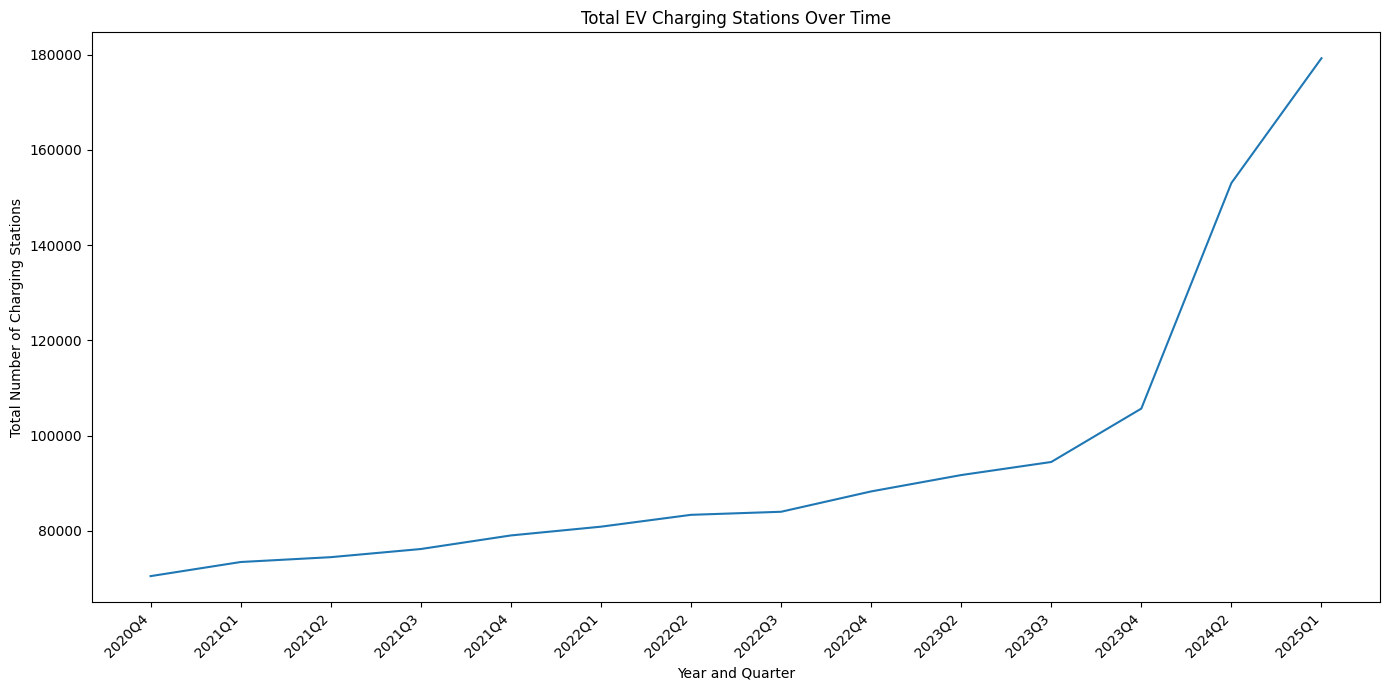

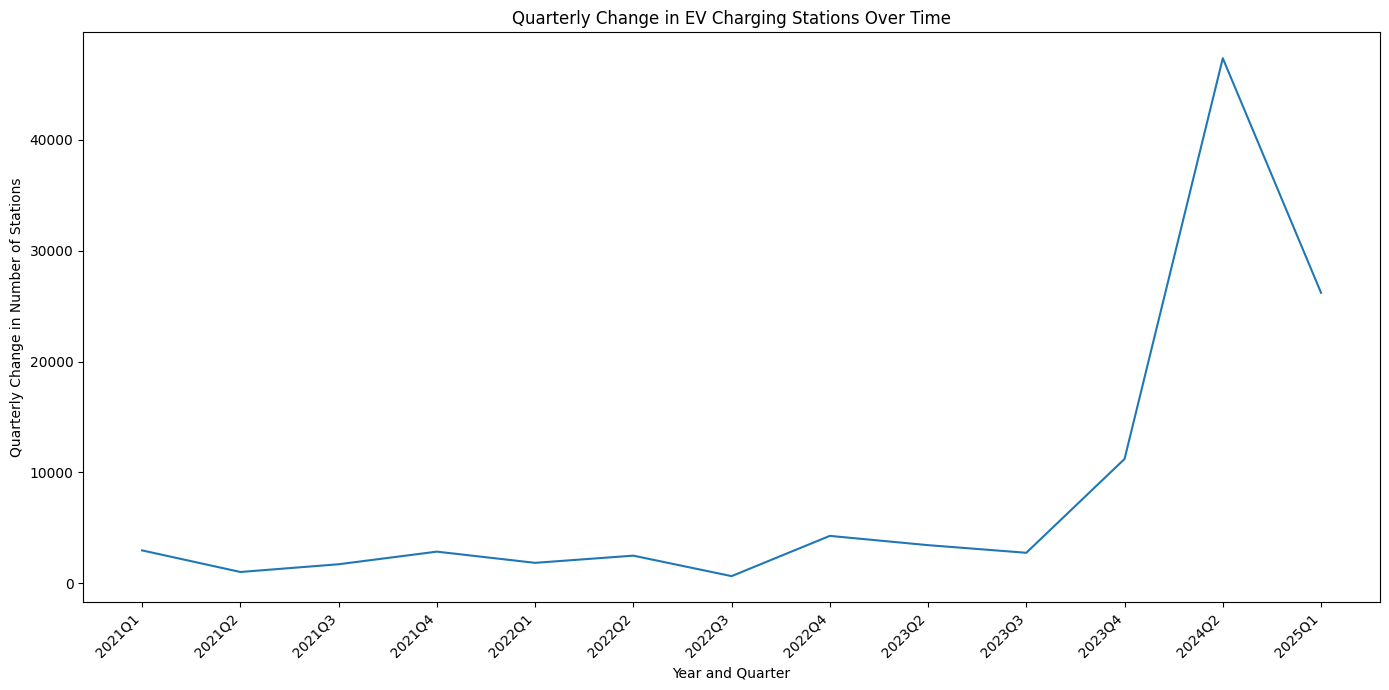

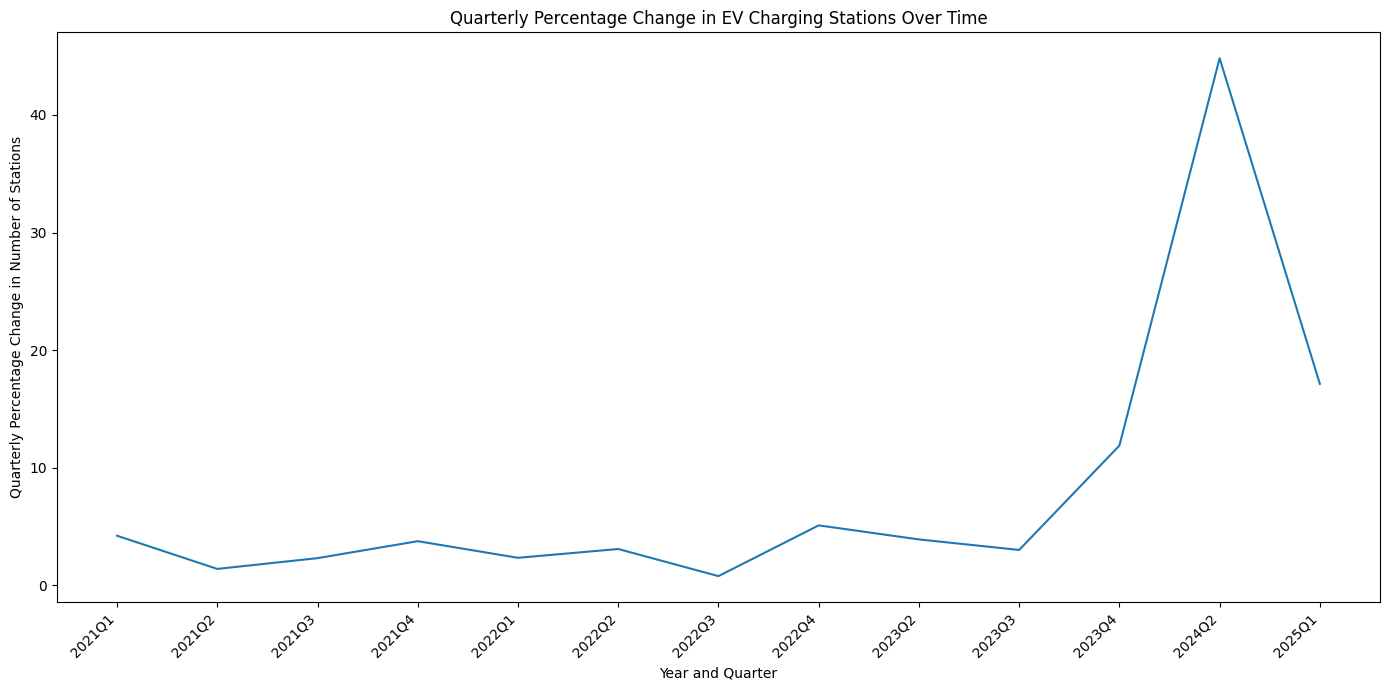

In [20]:


# Group by Date and sum the total number of charging stations
charging_deployment_rate = ev_chargers_df.groupby('Date_Period')['Total'].sum().reset_index()
charging_deployment_rate['Date_Period'] = charging_deployment_rate['Date_Period'].astype(str)

# Calculate the quarter-over-quarter change in the number of charging stations
charging_deployment_rate['Quarterly Change'] = charging_deployment_rate['Total'].diff()

# Calculate the percentage change quarter-over-quarter
charging_deployment_rate['Quarterly Percentage Change'] = charging_deployment_rate['Total'].pct_change() * 100

# Display the calculated rates
print("Quarterly Deployment Rate of EV Charging Stations:")
display(charging_deployment_rate)

# Plot the total number of charging stations over time to visualize the deployment rate
plt.figure(figsize=(14, 7))
plt.plot(charging_deployment_rate['Date_Period'], charging_deployment_rate['Total'])
plt.xlabel('Year and Quarter')
plt.ylabel('Total Number of Charging Stations')
plt.title('Total EV Charging Stations Over Time')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot the quarterly change in the number of charging stations
plt.figure(figsize=(14, 7))
plt.plot(charging_deployment_rate['Date_Period'], charging_deployment_rate['Quarterly Change'])
plt.xlabel('Year and Quarter')
plt.ylabel('Quarterly Change in Number of Stations')
plt.title('Quarterly Change in EV Charging Stations Over Time')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot the quarterly percentage change in the number of charging stations
plt.figure(figsize=(14, 7))
plt.plot(charging_deployment_rate['Date_Period'], charging_deployment_rate['Quarterly Percentage Change'])
plt.xlabel('Year and Quarter')
plt.ylabel('Quarterly Percentage Change in Number of Stations')
plt.title('Quarterly Percentage Change in EV Charging Stations Over Time')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# ***5.  Modeling***

Use regression models to predict the number of EV charging stations in the next 5 years using the `ev_chargers_df` dataframe.
<br></br>
First create a time series dataset for the total number of charging stations over time using the `ev_chargers_df` dataframe.

In [21]:
charging_stations_time_series = ev_chargers_df.groupby('Date_Period')['Total'].sum().reset_index()
display(charging_stations_time_series.head())

charging_stations_time_series['Year'] = charging_stations_time_series['Date_Period'].dt.year
charging_stations_time_series['Quarter_Num'] = charging_stations_time_series['Date_Period'].dt.quarter

X = charging_stations_time_series[['Year', 'Quarter_Num']]
y = charging_stations_time_series['Total']

display(X.head())
display(y.head())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Data divided into training and testing sets.")

,Date_Period,Total
0,2020Q4,70479.0
1,2021Q1,73443.0
2,2021Q2,74459.0
3,2021Q3,76172.0
4,2021Q4,79023.0


,Year,Quarter_Num
0,2020,4
1,2021,1
2,2021,2
3,2021,3
4,2021,4


,Total
0,70479.0
1,73443.0
2,74459.0
3,76172.0
4,79023.0


Data divided into training and testing sets.


# ***5.  Modeling - regression models***

Train regression models:
*   Linear regression
*   Ridge regression
*   Lasso regression




In [22]:
# Initialize and train the Linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Initialize and train the Ridge regression model
ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train, y_train)

# Initialize and train the Lasso regression model
lasso_model = Lasso(alpha=1.0, random_state=42)
lasso_model.fit(X_train, y_train)

print("Regression models (Linear Regression, Ridge, and Lasso) have been trained.")

# Make predictions on the test set
y_pred_linear = linear_model.predict(X_test)
y_pred_ridge = ridge_model.predict(X_test)
y_pred_lasso = lasso_model.predict(X_test)

# Calculate regression metrics for Linear Regression model
mae_linear = mean_absolute_error(y_test, y_pred_linear)
mse_linear = mean_squared_error(y_test, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)
r2_linear = r2_score(y_test, y_pred_linear)

# Calculate regression metrics for Ridge model
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

# Calculate regression metrics for Lasso model
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mse_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

# Print the metrics for each model
print("Linear Regression Metrics:")
print(f"Mean Absolute Error (MAE): {mae_linear}")
print(f"Mean Squared Error (MSE): {mse_linear}")
print(f"Root Mean Squared Error (RMSE): {rmse_linear}")
print(f"R-squared: {r2_linear}")
print("=========================================================================")

print("Ridge Regression Metrics:")
print(f"Mean Absolute Error (MAE): {mae_ridge}")
print(f"Mean Squared Error (MSE): {mse_ridge}")
print(f"Root Mean Squared Error (RMSE): {rmse_ridge}")
print(f"R-squared: {r2_ridge}")
print("=========================================================================")

print("Lasso Regression Metrics:")
print(f"Mean Absolute Error (MAE): {mae_lasso}")
print(f"Mean Squared Error (MSE): {mse_lasso}")
print(f"Root Mean Squared Error (RMSE): {rmse_lasso}")
print(f"R-squared: {r2_lasso}")

Regression models (Linear Regression, Ridge, and Lasso) have been trained.
Linear Regression Metrics:
Mean Absolute Error (MAE): 21590.414381474257
Mean Squared Error (MSE): 541704794.6265575
Root Mean Squared Error (RMSE): 23274.552511843434
R-squared: -1.5883820434683091
Ridge Regression Metrics:
Mean Absolute Error (MAE): 19821.832608980436
Mean Squared Error (MSE): 467944342.9489147
Root Mean Squared Error (RMSE): 21632.021240487786
R-squared: -1.2359387375674635
Lasso Regression Metrics:
Mean Absolute Error (MAE): 21589.81947794308
Mean Squared Error (MSE): 541659697.9440514
Root Mean Squared Error (RMSE): 23273.583693622506
R-squared: -1.5881665618178298


# ***5.  Modeling - Predict future charging stations***

### Subtask:
Use the best-performing model to predict the number of charging stations for the next 5 years.


Future predictions for charging stations (next 5 years) using the best Ridge model:


,Date_Period,Predicted_Total_Charging_Stations
0,2025Q3,161458.628210
1,2025Q4,159825.548005
2,2026Q1,187988.578032
3,2026Q2,186355.497827
4,2026Q3,184722.417621


,Date_Period,Predicted_Total_Charging_Stations
15,2029Q2,256146.866061
16,2029Q3,254513.785855
17,2029Q4,252880.705650
18,2030Q1,281043.735678
19,2030Q2,279410.655472


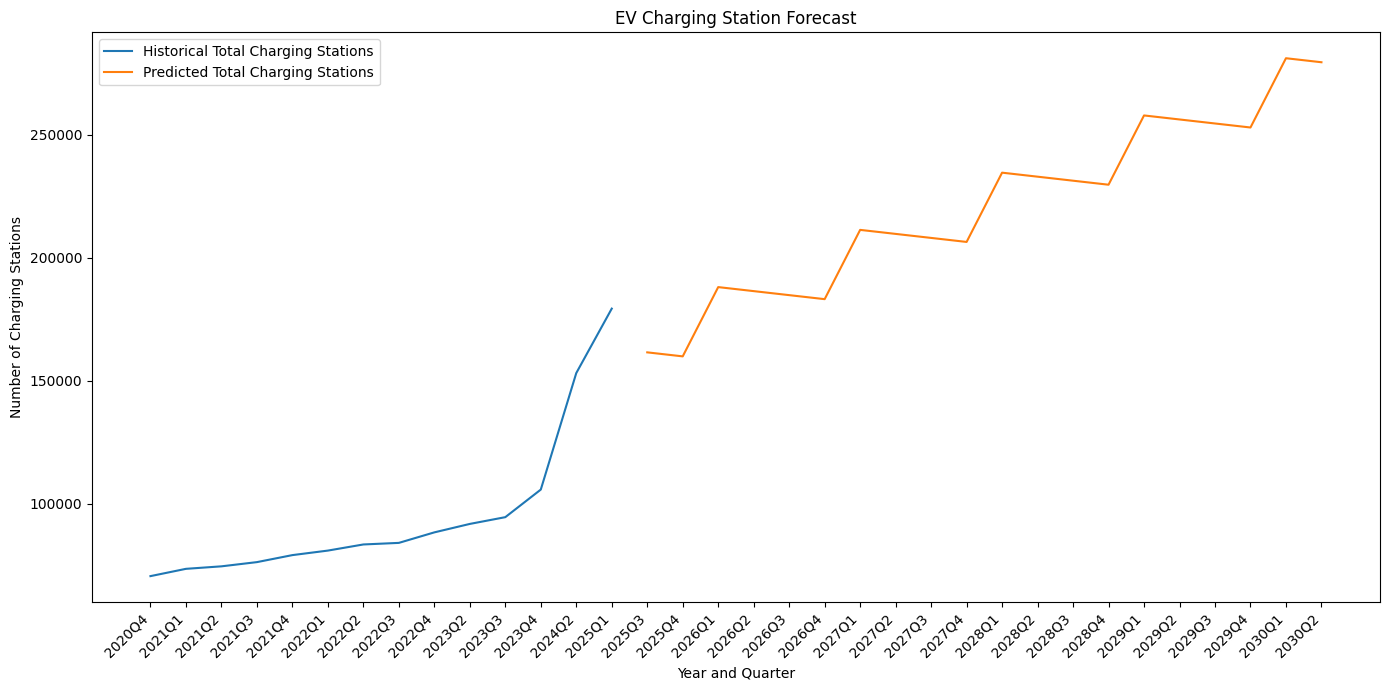

In [23]:
# Create future time periods for the next 5 years (2025Q3 to 2030Q2)
future_quarters = pd.period_range(start='2025Q3', periods=5*4, freq='Q')

# Create a DataFrame for future predictions
future_data = pd.DataFrame({
    'Year': future_quarters.year,
    'Quarter_Num': future_quarters.quarter
})

# Predict the number of charging stations for future periods using the best Ridge model
future_predictions_ridge = ridge_model.predict(future_data)

# Store the predictions in a DataFrame
future_predictions_df = pd.DataFrame({
    'Date_Period': future_quarters.astype(str),
    'Predicted_Total_Charging_Stations': future_predictions_ridge
})

print("Future predictions for charging stations (next 5 years) using the best Ridge model:")
display(future_predictions_df.head())
display(future_predictions_df.tail())


# Plot the historical and predicted charging station data.
plt.figure(figsize=(14, 7))
plt.plot(charging_stations_time_series['Date_Period'].astype(str), charging_stations_time_series['Total'], label='Historical Total Charging Stations')
plt.plot(future_predictions_df['Date_Period'], future_predictions_df['Predicted_Total_Charging_Stations'], label='Predicted Total Charging Stations')
plt.xlabel('Year and Quarter')
plt.ylabel('Number of Charging Stations')
plt.title('EV Charging Station Forecast')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## EV charging stations prediction Summary:

### Data Analysis Key Findings

*   Regression models (Linear Regression, Ridge, and Lasso) were trained to predict the number of EV charging stations based on year and quarter.
*   Model evaluation using MAE, MSE, RMSE, and R-squared showed negative R-squared values, indicating insuifficient data was  for this time series forecasting task.
*   Among the tested models, Ridge Regression had slightly lower error metrics (MAE, MSE, RMSE) on the test set compared to Linear and Lasso Regression.
*   Using the Ridge model, the predicted number of charging stations for the next 5 years (from 2025Q3 to 2030Q2) were generated, with low reliability of these predictions.

### Insights or Next Steps
*   The current regression approach based solely on year and quarter is not effective for forecasting EV charging stations, suggesting to incorporate additional relevant features.
*   Further investigation is needed to understand the underlying patterns and potential external factors influencing the growth of EV charging stations to build a more accurate predictive model.

## Estimate electricity consumption per ev
Making reasonable assumptions about the average electricity consumption of an electric vehicle per unit of distance or time.

<br></br>
## Estimate total electricity consumption from projected zev sales
Use the predicted ZEV sales for the next 5 years (which we just calculated) and the estimated consumption per EV to project the total electricity consumption due to the increased EV fleet.

In [27]:
# Estimate total electricity consumption from existing ZEV sales

# Assuming the same average annual electricity consumption per EV in kWh
if 'avg_kwh_per_ev_per_year' not in locals():
    avg_kwh_per_ev_per_year = 3500

# Calculate the total number of ZEVs sold up to the latest date in the dataset
# We assume zev_sales_df is available from a previous cell execution
if 'zev_sales_df' in locals():
    total_existing_zev_sales = zev_sales_df['Number of Vehicles'].sum()

    # Estimate the total annual electricity consumption by existing ZEVs
    estimated_total_kwh_existing_zev = total_existing_zev_sales * avg_kwh_per_ev_per_year

    print(f"Estimated average annual electricity consumption per EV: {avg_kwh_per_ev_per_year} kWh")
    print(f"Total number of existing ZEVs based on sales data: {total_existing_zev_sales:,.0f}")
    print(f"Estimated total annual electricity consumption by existing ZEVs: {estimated_total_kwh_existing_zev:,.2f} kWh")

else:
    print("Error: zev_sales_df not found. Please ensure the data loading cell (cell S28sAoE7QNfj) has been executed.")

print("\nAccording to the U.S. Energy Information Administration (EIA) reported that EV electricity consumption in California rose by over 50% by early 2024.")
print("With the number of ZEV sales increasing, the electricty demand continues to rise year-over-year.")

Estimated average annual electricity consumption per EV: 3500 kWh
Total number of existing ZEVs based on sales data: 2,343,387
Estimated total annual electricity consumption by existing ZEVs: 8,201,854,500.00 kWh

According to the U.S. Energy Information Administration (EIA) reported that EV electricity consumption in California rose by over 50% by early 2024.
With the number of ZEV sales increasing, the electricty demand continues to rise year-over-year.
